# Эксперимент: Matrix Symmetrical Factorization on strong-convex set FW and BPG

### Целевая функция

Эксперименты проводились на функции Matrix Symmetrical Factorization в положительном ортанте:
$$
\begin{array}{ll}
\textrm{minimize}   & F(X):= \| M - X X^\top \| \\
& X \geq 0 \\ 
\end{array}
$$
, где $M \in \mathbb{R}^{n \times n}$ и $X \in \mathbb{R}^{n \times r}$.

Относительная гладкость бралась с полиномиальной прокс-функцией с константами $L = 1, \alpha  = 6, \sigma  = 2 \| M\|$ (доказательство констант см. в работе Radu-Alexandru Dragomir, Alexandre d’Aspremont, J´erˆome Bolte. Quartic first-order
methods for low-rank minimization)
$$
d(X)=\dfrac{\alpha}{4}\|X\|^4+\dfrac{\sigma}{2}\|X\|^2 \quad {\forall X \in \mathbb{R}^{n \times r}}
$$. 

### Данные 
Эксперименты проводились на следующих данных:
- случайно сгенерированные данные: плотная матрица
- случайно сгенерированные данные: разреженная матрица

Начальная точка бралась внутри допустимой области определения.

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с адаптивными параметрами $L$ и $\gamma$ (FW-adapt-full)
- Алгоритм Франк-Вульфа с адаптивным параметром $L$ и фиксированным $\gamma$ (FW-adapt-L)
- Алгоритм Франк-Вульфа с фиксированными параметрами $L$ и $\gamma$ (FW-Bregman)
- Алгоритм Франк-Вульфа с убывающим шагом $\frac{2}{k + 1}$. Алгоритм не зависит ни от каких параметров (FW-Descent Step)

### Цель эксперимента

Ответим на вопросы
1) В предыдущих экспериментах мы увидели, что метод FW с шагом $\alpha(k) = \frac{2}{k+2}$ превзошел shortest step. Поэтому возник вопрос а при каких условиях shortest step будет выигрышным вариантом? Так же у нас существует теоретическая ускоренная оценка для сильно выпуклых множеств для shortest step шага, однако для шага $\alpha(k) = \frac{2}{k+2}$ оптимальной оценкой явлестся лишь $O(1/k)$, поэтому проверим на реальном эксперименте будет ли явное преимущество shortest step.
2) Даст ли адаптивность и тут ускорение как в предыдущих экспериментах?
3) Изначальная гипотеза, что $\gamma$ лучше менять пореже, поэтому проверить, как отразится на производительности алгоритма, если менять $\gamma$ каждые 2, 10, 50, 100 итераций?

Так как для метода FW множество должно быть ограниченным, то мы проведем два эксперимента: на $l_2$-шаре и на $l_\infty$-шаре (он представляет из себя политоп). Т.к. наша цель посмотреть действительно ли shortest step очень хорошо работает на сильно-выпуклых множествах, то мы таким способом увидим действительно ли это так. 

Так в условии задачи явно требуется, что $X$ - положительно определенная матрица, то шары будут взяты в положительном ортанте и решение так же было положено внутрь шара, чтобы метод не "упирался" в край множества.

In [40]:
import numpy as np
from matplotlib import pyplot as plt

import sys
import os

notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

import accbpg

## Факторизация матрицы на l2 шаре (сильно-выпуклое множество).

В этом эксперименте будет рассмотрено ограничение в виде $l_2$ шара:

$$\textrm{subject to} \ \ X \in B_2(C, radius)$$
, где $B_2$ - $l_2$-шар с центром в $C$ и радиусом $radius$.

In [41]:
max_iters = 200
verbskip = 50
ls_ratio = 2.0
divisor_for_tse = 1.05
gamma = 2.0
epsilon = 1e-9

approx_mx_dim = 400
x_dim_2 = 50
set_diameter = 1000.0
radius = set_diameter / 2

assert x_dim_2 < approx_mx_dim, "r should be less than n"

ball_center = np.ones((approx_mx_dim, x_dim_2)) * radius
f, h, L, X0, approx_matrix = accbpg.FrobeniusSymLossExL2Ball(approx_mx_dim, x_dim_2, ball_center, radius=radius, on_boundary=False)

assert np.linalg.norm(X0 - ball_center, 2) <= radius, "X0 must lie inside the ball"

fw_lmo = accbpg.lmo_l2_ball(radius, center=ball_center)

In [42]:
x_full_adapt, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
)
x_L_adapt, F00_L_adapt, _, T_adapt = accbpg.FW_alg_div_step(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    linesearch=True, ls_ratio=ls_ratio, verbskip=verbskip
)
x_bregman, F00_bregman, _, T_bregman = accbpg.FW_alg_div_step(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    linesearch=False, verbskip=verbskip
)
x_descent_step, F00_descent_step, T_descent_step, _ = accbpg.FW_alg_descent_step(
    f, h, X0, maxitrs=max_iters, lmo=fw_lmo, verbskip=verbskip
)


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   9.178e+15   5.000e-01     0.0   2.000e+00

FW adaptive algorithm
     k      F(x)         Lk       time
     0   9.178e+15   5.000e-01     0.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   9.178e+15   1.000e+00     0.0
    50   3.676e+15   1.000e+00     0.0

FW descent step size algorithm
     k      F(x)         alpha_k       time
     1   5.231e+15   6.667e-01     0.0
    50   3.680e+15   3.846e-02     0.0
   100   3.677e+15   1.961e-02     0.1
   150   3.677e+15   1.316e-02     0.1


In [43]:
eps = 1e-6
assert np.linalg.norm(x_full_adapt - ball_center, 2) <= radius + eps
assert np.linalg.norm(x_L_adapt - ball_center, 2) <= radius + eps
assert np.linalg.norm(x_bregman - ball_center, 2) <= radius + eps
assert np.linalg.norm(x_descent_step - ball_center, 2) <= radius + eps

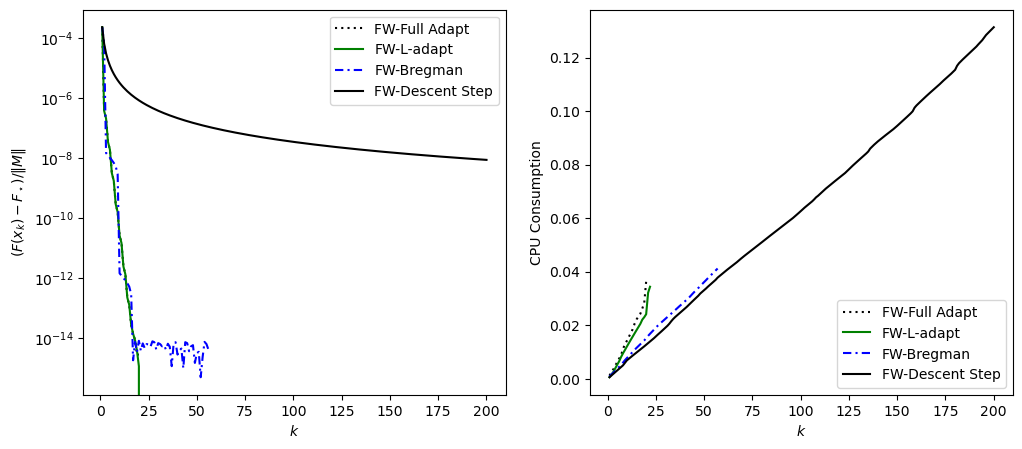

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

labels = [r"FW-Full Adapt", r"FW-L-adapt", r"FW-Bregman", r"FW-Descent Step"]

y_vals = [F00_full_adapt / np.linalg.norm(approx_matrix)**2, 
            F00_L_adapt / np.linalg.norm(approx_matrix)**2, 
            F00_bregman / np.linalg.norm(approx_matrix)**2, 
            F00_descent_step / np.linalg.norm(approx_matrix)**2
            ]
accbpg.plot_comparisons(
    ax1, y_vals, labels, x_vals=[], plotdiff=True, yscale="log",
    xlabel=r"$k$", ylabel=r"($F(x_k)-F_\star) / \| M \|$", legendloc="upper right",
)

y_vals = [T_full_adapt, T_adapt, T_bregman, T_descent_step]
accbpg.plot_comparisons(
    ax2, y_vals, labels, x_vals=[], plotdiff=False, yscale="linear",
    xlabel=r"$k$", ylabel=r'CPU Consumption', legendloc="lower right",
)

## Факторизация матрицы на $l_\infty$ шаре (политоп).

В этом эксперименте будет рассмотрено ограничение в виде $l_\infty$ шара:

$$\textrm{subject to} \ \ X \in B_\infty(C, radius)$$
, где $B_\infty$ - $l_\infty$-шар с центром в $C$ и радиусом $radius$.

Определение $l_\infty$ нормы $\| X \| = \text{max}_{i,j} | X_{i,j} |$

In [45]:
# np.random.seed(119)
max_iters = 200
verbskip=10
ls_ratio = 2.0
divisor_for_tse = 1.05
gamma = 2.0
epsilon = 1e-9

approx_mx_dim = 400
x_dim_2 = 50
set_diameter = 1000.0
radius = set_diameter / 2

assert x_dim_2 < approx_mx_dim, "r should be less than n"

ball_center = np.ones((approx_mx_dim, x_dim_2)) * radius
f, h, L, X0, approx_matrix = accbpg.FrobeniusSymLossExLInfBall(approx_mx_dim, x_dim_2, ball_center, radius=radius, on_boundary=False)

assert np.max(np.abs(X0 - ball_center)) <= radius + 1e-6, "X0 must lie inside the ball"

fw_lmo = accbpg.lmo_linf_ball(radius, center=ball_center)

In [46]:
x_full_adapt, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse, verbskip=verbskip
)
x_L_adapt, F00_L_adapt, _, T_adapt = accbpg.FW_alg_div_step(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    linesearch=True, ls_ratio=ls_ratio, verbskip=verbskip
)
x_bregman, F00_bregman, _, T_bregman = accbpg.FW_alg_div_step(
    f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
    linesearch=False, verbskip=verbskip
)
x_descent_step, F00_descent_step, T_descent_step, _ = accbpg.FW_alg_descent_step(
    f, h, X0, maxitrs=max_iters, lmo=fw_lmo, verbskip=verbskip
)

eps = 1e-6
assert np.max(np.abs(x_full_adapt - ball_center)) <= radius + eps
assert np.max(np.abs(x_L_adapt - ball_center)) <= radius + eps
assert np.max(np.abs(x_bregman - ball_center)) <= radius + eps
assert np.max(np.abs(x_descent_step - ball_center)) <= radius + eps


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   8.844e+14   5.000e-01     0.0   2.000e+00
    10   2.535e+13   2.500e-01     0.0   2.000e+00
    20   1.081e+13   2.500e-01     0.0   2.000e+00
    30   6.850e+12   2.500e-01     0.1   2.000e+00
    40   5.208e+12   2.500e-01     0.1   1.952e+00
    50   4.202e+12   2.500e-01     0.1   1.952e+00
    60   3.547e+12   2.500e-01     0.1   2.000e+00
    70   3.153e+12   2.500e-01     0.1   2.000e+00
    80   2.928e+12   2.500e-01     0.1   1.952e+00
    90   2.757e+12   1.250e-01     0.1   2.000e+00
   100   2.558e+12   1.250e-01     0.2   2.000e+00
   110   2.406e+12   1.250e-01     0.2   2.000e+00
   120   2.283e+12   1.250e-01     0.2   2.000e+00
   130   2.173e+12   1.250e-01     0.3   2.000e+00
   140   2.071e+12   1.250e-01     0.4   2.000e+00
   150   1.991e+12   2.500e-01     0.4   2.000e+00
   160   1.919e+12   2.500e-01     0.4   2.000e+00
   170   1.856e+12   2.500e-01     0.4   2.000e+00
   

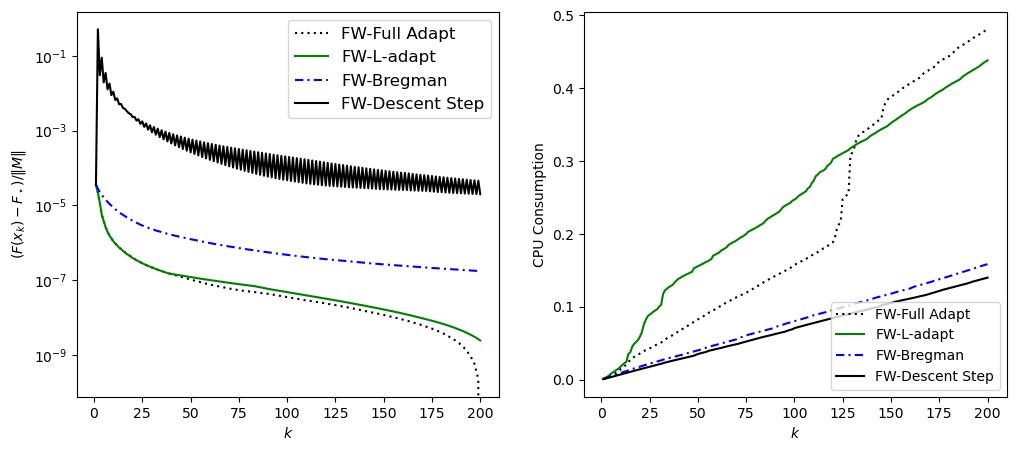

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

labels = [r"FW-Full Adapt", r"FW-L-adapt", r"FW-Bregman", r"FW-Descent Step"]

y_vals = [F00_full_adapt / np.linalg.norm(approx_matrix)**2, 
            F00_L_adapt / np.linalg.norm(approx_matrix)**2, 
            F00_bregman / np.linalg.norm(approx_matrix)**2, 
            F00_descent_step / np.linalg.norm(approx_matrix)**2
            ]
accbpg.plot_comparisons(
    ax1, y_vals, labels, x_vals=[], plotdiff=True, yscale="log",
    xlabel=r"$k$", ylabel=r"($F(x_k)-F_\star) / \| M \|$", legendloc="upper right",
)

y_vals = [T_full_adapt, T_adapt, T_bregman, T_descent_step]
accbpg.plot_comparisons(
    ax2, y_vals, labels, x_vals=[], plotdiff=False, yscale="linear",
    xlabel=r"$k$", ylabel=r'CPU Consumption', legendloc="lower right",
)

# Ensure the legend is created before modifying it
ax1.legend(fontsize=12)

## Изменение частоты изменения параметра $\gamma$

In [48]:
# np.random.seed(119)
max_iters = 200
verbskip = 50
ls_ratio = 2.0
divisor_for_tse = 1.05
gamma = 2.0
epsilon = 1e-9

approx_mx_dim = 700
x_dim_2 = 50
set_diameter = 1000.0
radius = set_diameter / 2

assert x_dim_2 < approx_mx_dim, "r should be less than n"

ball_center = np.ones((approx_mx_dim, x_dim_2)) * radius
f, h, L, X0, approx_matrix = accbpg.FrobeniusSymLossExLInfBall(
    approx_mx_dim, x_dim_2, ball_center, radius=radius, on_boundary=False
)

assert np.max(np.abs(X0 - ball_center)) <= radius + 1e-6, "X0 must lie inside the ball"

fw_lmo = accbpg.lmo_linf_ball(radius, center=ball_center)

In [49]:
change_tse_values = [2, 4, 8, 50]
labels = [rf"$\Delta={val}$" for val in change_tse_values]

F00_full_adapt_list = []
T_full_adapt_list = []

for change_tse_each_n in change_tse_values:
    _, F00_full_adapt, _, T_full_adapt, _ = accbpg.FW_alg_div_step_adapt(
        f, h, L, X0, maxitrs=max_iters, gamma=gamma, lmo=fw_lmo,
        ls_ratio=ls_ratio, divisor_for_tse=divisor_for_tse,
        verbskip=verbskip, change_tse_each_n=change_tse_each_n
    )
    F00_full_adapt_list.append(F00_full_adapt / np.linalg.norm(approx_matrix)**2)
    T_full_adapt_list.append(T_full_adapt)


FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   3.162e+16   5.000e-01     0.0   2.000e+00
    50   4.565e+14   2.500e-01     0.2   2.000e+00
   100   3.532e+14   2.500e-01     0.3   2.000e+00
   150   3.194e+14   2.500e-01     0.7   2.000e+00

FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   3.162e+16   5.000e-01     0.0   2.000e+00
    50   4.774e+14   2.500e-01     0.2   2.000e+00
   100   3.579e+14   2.500e-01     0.4   2.000e+00
   150   3.215e+14   2.500e-01     0.6   2.000e+00

FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   3.162e+16   5.000e-01     0.0   2.000e+00
    50   4.774e+14   2.500e-01     0.2   2.000e+00
   100   3.579e+14   2.500e-01     0.3   2.000e+00
   150   3.215e+14   2.500e-01     0.5   2.000e+00

FW full adaptive algorithm
     k      F(x)         Lk       time       gamma
     0   3.162e+16   5.000e-01     0.0   2.000e+00
    50   4.774e+14   

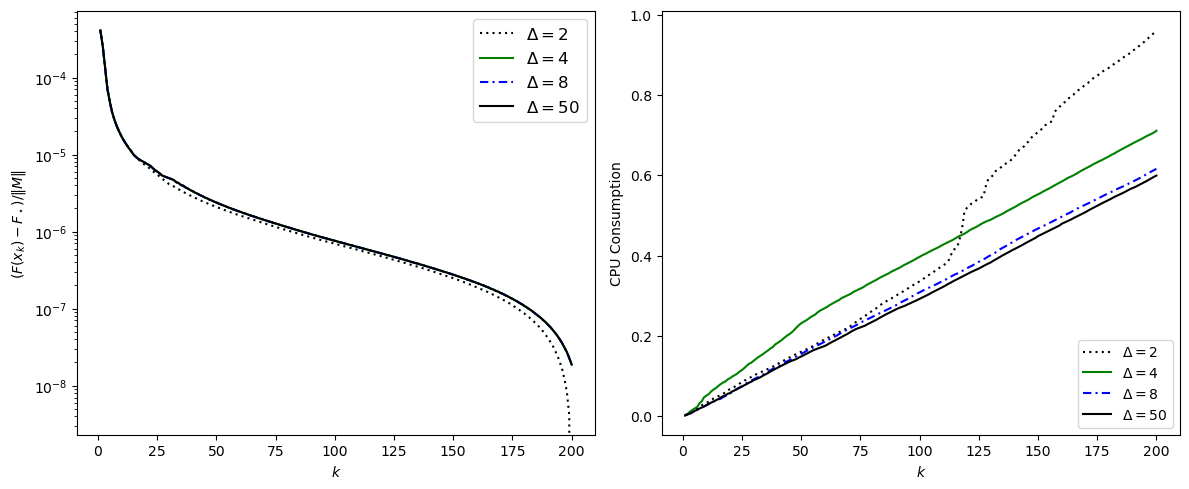

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

accbpg.plot_comparisons(
    ax1, F00_full_adapt_list, labels,
    x_vals=[], plotdiff=True, yscale="log",
    xlabel=r"$k$", ylabel=r"($F(x_k)-F_\star) / \| M \|$", legendloc="upper right"
)

accbpg.plot_comparisons(
    ax2, T_full_adapt_list, labels,
    x_vals=[], plotdiff=False, yscale="linear",
    xlabel=r"$k$", ylabel=r"CPU Consumption", legendloc="lower right"
)

ax1.legend(fontsize=12)
plt.tight_layout()


# Выводы

Эксперимент совершенно явно показывает, что на сильно-выпуклом множестве shortest step колоссально обходит убывающий шаг. Это полностью согласуется с теорией, которая говорит о том, что на сильно выпуклых множествах сходимость ускоренная. 

Убывающий шаг же не имеем ускоренных теоретических оценок и это подтвердилось на практике. Однако он отстал и на политопе. Возможно это происходит из-за высокой размерности задач и большого радиуса множества, т.к. метод не умпевает на первых шагах доходить до нужного уровня.

Лучше ли полностью адаптивный шаг $L, \gamma$ по сравнению с шагом адаптивным только по $L$. На первом эксперименте этого не видно, т.к. метод сходятся очень быстро. Но вот на втором видно небольшое превосходство метода.

3) На удивление тут частота изменения $\gamma$ влияет очень слабо. Подозреваю из-за того, что малейшее изменение параметров сразу проходит через условия и до изменения \gamma не доходит даже на второй итерации